# Lisbon Machine Learning School
## Exercise 3: data preprocessing, and neural network structure

(C) Pietro Vischia (Universidad de Oviedo and ICTEA), pietro.vischia@cern.ch


## Setup the environment

- If you are running locally, you don't need to run anything

- If you are running on Google Colab, uncomment and run the next cell (remove only the "#", keep the "!"). You can also run it from a local installation, but it will do nothing if you have already installed all dependencies (and it will take some time to tell you it is not gonna do anything).



In [1]:
#from google.colab import drive
#drive.mount('/content/drive')
#%cd "/content/drive/MyDrive/"
#! git clone https://github.com/vischia/lisbon-ml-school.git
#%cd lisbon-ml-school
#!pwd
#!ls

## Load the needed libraries

In [2]:
import os

import torch
import torch.nn as nn  
import torch.optim as optim 
from torch.utils.data import Dataset, DataLoader 
import torch.nn.functional as F 
import torchvision
import torchinfo
from tqdm import tqdm

import sklearn
import sklearn.model_selection
from sklearn.metrics import roc_curve, auc, accuracy_score

import uproot

import pandas as pd

import matplotlib
matplotlib.rcParams['figure.figsize'] = (8, 6)
matplotlib.rcParams['axes.labelsize'] = 14
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.backends.mps.is_available():
    device = torch.device("mps")
    torch.set_default_dtype(torch.float32)

print('Using torch version', torch.__version__)

Using torch version 2.6.0


## Load the data

We will use simulated events corresponding to three physics processes.
- ttH production
- ttW production
- Drell-Yan ($pp\\to Z/\\gamma^*$+jets) production

We will select the multilepton final state, which is a challenging final state with a rich structure and nontrivial background separation.

<img src="figs/2lss.png" alt="ttH multilepton 2lss" style="width:40%"/>

We use the [uproot](https://uproot.readthedocs.io/en/latest/basic.html) library to conveniently read in a [ROOT TNuple](https://root.cern.ch/doc/master/classTNtuple.html) which can automatically convert it to a [pandas dataframe](https://pandas.pydata.org/).

In [3]:
# Download the data only if you haven't done so yet

if not os.path.isfile("data/signal.root"): 
    !mkdir data; cd data/; wget https://www.hep.uniovi.es/vischia/cmsdas2024/ft_tth_multilep_igfae2024.tar.gz; tar xzvf ft_tth_multilep_igfae2024.tar.gz; mv igfae2024/* .; rmdir igfae2024; rm ft_tth_multilep_igfae2024.tar.gz; cd -;


In [4]:
INPUT_FOLDER = './data'

sig = uproot.open(os.path.join(INPUT_FOLDER,'signal.root'))['Friends'].arrays(library="pd")
bk1 = uproot.open(os.path.join(INPUT_FOLDER,'background_1.root'))['Friends'].arrays(library="pd")
bk2 = uproot.open(os.path.join(INPUT_FOLDER,'background_2.root'))['Friends'].arrays(library="pd")

### Data inspection

The first thing you need to do when building a machine learning model is to forget about the model, and **just look at the data**


Let's start by looking at which features and labels are available in these files
   

In [5]:
sig.columns

Index(['Hreco_Lep0_pt', 'Hreco_Lep1_pt', 'Hreco_Lep2_pt', 'Hreco_HadTop_pt',
       'Hreco_All5_Jets_pt', 'Hreco_More5_Jets_pt', 'Hreco_Jets_plus_Lep_pt',
       'Hreco_Lep0_eta', 'Hreco_Lep1_eta', 'Hreco_Lep2_eta',
       'Hreco_HadTop_eta', 'Hreco_All5_Jets_eta', 'Hreco_More5_Jets_eta',
       'Hreco_Jets_plus_Lep_eta', 'Hreco_Lep0_phi', 'Hreco_Lep1_phi',
       'Hreco_Lep2_phi', 'Hreco_HadTop_phi', 'Hreco_All5_Jets_phi',
       'Hreco_More5_Jets_phi', 'Hreco_Jets_plus_Lep_phi', 'Hreco_Lep0_mass',
       'Hreco_Lep1_mass', 'Hreco_Lep2_mass', 'Hreco_HadTop_mass',
       'Hreco_All5_Jets_mass', 'Hreco_More5_Jets_mass',
       'Hreco_Jets_plus_Lep_mass', 'Hreco_TopScore', 'Hreco_met',
       'Hreco_met_phi', 'Hreco_HTXS_Higgs_pt', 'Hreco_HTXS_Higgs_y',
       'Hreco_evt_tag'],
      dtype='object')

Most of the variables are input features, corresponding to detector measurements of the properties of the reconstructed decay products.

There are three special variables, though:

- `Hreco_evt_tag`: this feature has values in ${0,1}$, where $1$ flags the event as signal event, and $0$ flags the event as background event;
- `Hreco_HTXS_Higgs_pt`: this feature contains the true generate Higgs boson transverse momentum at generator level (used for regression);
- `Hreco_HTXS_Higgs_y`: this feature contains the true generated Higgs boson rapidity (not pseudorapidity) at generator level (used for regression).

You'll see down below that we will have of course to ignore some of all of these three features (they are not input features).

### Plotting histograms of some observables using matplotlib
(see also examples on [matplotlib](https://matplotlib.org/3.5.3/api/_as_gen/matplotlib.pyplot.html) website)

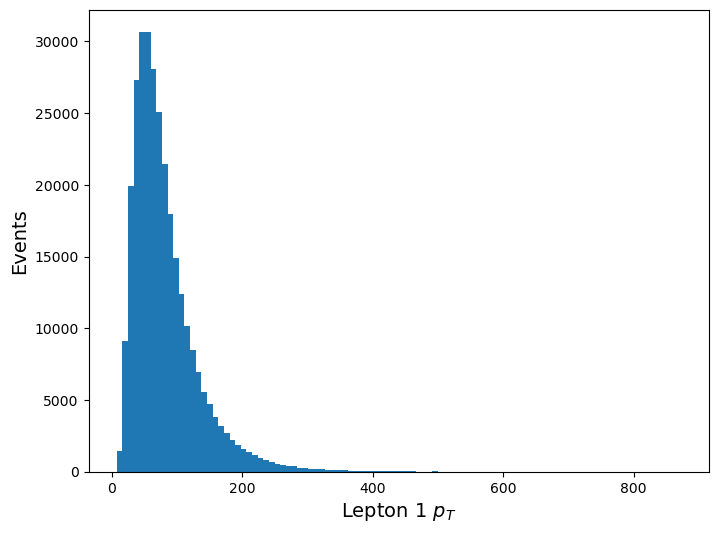

In [6]:
plt.figure()
plt.hist(sig["Hreco_Lep0_pt"], bins=100)
plt.xlabel("Lepton 1 $p_T$")
plt.ylabel("Events")
plt.show()
plt.close()

We can also do scatter plots of one variable against the other

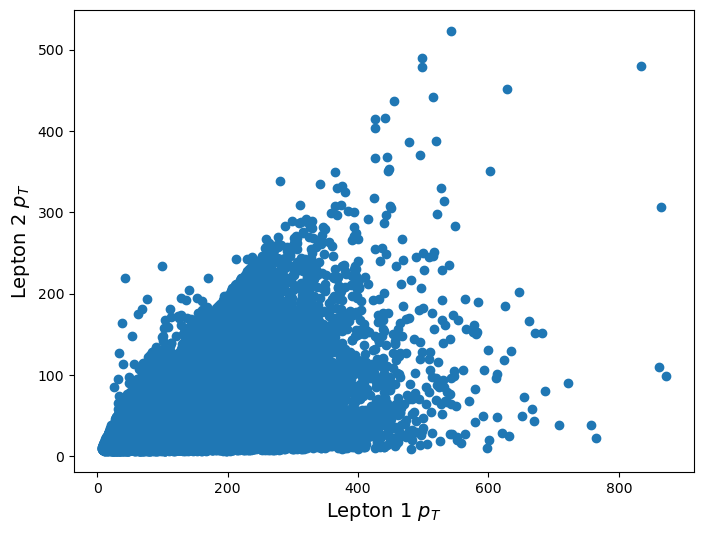

In [7]:
plt.figure()
plt.scatter(sig["Hreco_Lep0_pt"], sig["Hreco_Lep1_pt"])
plt.xlabel("Lepton 1 $p_T$")
plt.ylabel("Lepton 2 $p_T$")
plt.show()
plt.close()

And another variable, the transverse momentum of the third lepton

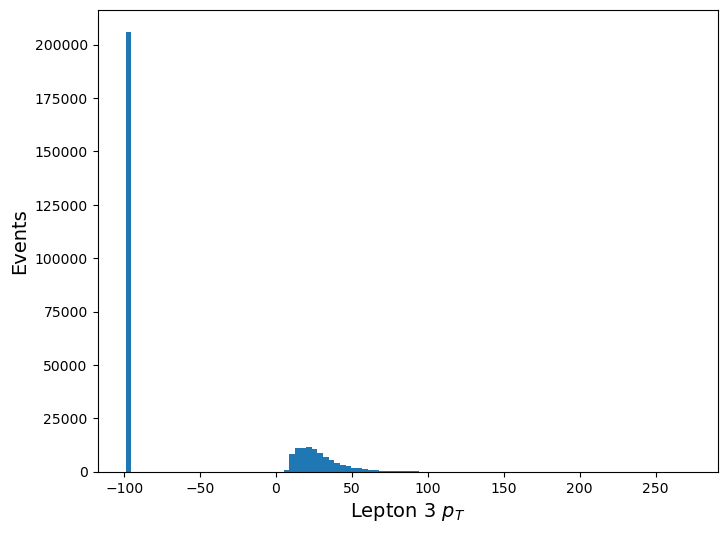

In [8]:
plt.figure()
plt.hist(sig["Hreco_Lep2_pt"], bins=100)
plt.xlabel("Lepton 3 $p_T$")
plt.ylabel("Events")
plt.show()
plt.close()

What is going on in the last plot?


.

.

.

.

.

.

.

.



The events preselected in these files contain events that have **at least two** leptons with same electrical charge.

Events with three leptons fall into this category.

We have three choices:

1. train our algorithm on `2lss` events, by selecting only events where the third lepton transverse momentum **is not set**: `dataframe=dataframe[dataframe['Hreco_Lep2_pt']==-99]`
2. train our algorithm on `3l` events, by selecting only events where the third lepton transverse momentum **is set**: `dataframe=dataframe[dataframe['Hreco_Lep2_pt']>-99]`
3. train our algorithm on `2lss+3l` events. The default value of $-99$ in this case will act as a semi-categorical variable

Let's pick option (1). 

We will first create a label for signal or background events (we could also use the evt_tag variable), then join all datasets together, then filter events to keep only those corresponding to `2lss` events, and finally we will drop all the features corresponding to the third lepton, plus those corresponding to regression targets.

In [9]:
# Create a new column 'label' and set its value to 1 or 0 for all rows (=events)
sig['label'] = 1 
bk1['label'] = 0
bk2['label'] = 0

# Merge the two backgrounds into one dataframe
bkg = pd.concat([bk1, bk2])

print(f"bkg1 shape {bk1.shape}")
print(f"bkg2 shape {bk2.shape}")
print(f"bkg1+bkg2 shape {bkg.shape}")

# Merge the signal and background into one dataframe
print(f" Signal shape {sig.shape}")
print(f" Bkg shape {bkg.shape}")

data = pd.concat([sig,bkg])

print(f" Data shape {data.shape}")
print(data.columns)

# Drop unneeded features
data = data.drop(["Hreco_Lep2_pt", "Hreco_Lep2_eta", "Hreco_Lep2_phi", "Hreco_Lep2_mass", 
                  "Hreco_evt_tag","Hreco_HTXS_Higgs_pt", "Hreco_HTXS_Higgs_y"], axis=1 )
print(f" Data shape {data.shape}")
print(data.columns)
print(f"In this dataframe we finally have {data[data['label']==1].shape[0]} signal and {data[data['label']==0].shape[0]} background events")

bkg1 shape (556648, 35)
bkg2 shape (1034904, 35)
bkg1+bkg2 shape (1591552, 35)
 Signal shape (299287, 35)
 Bkg shape (1591552, 35)
 Data shape (1890839, 35)
Index(['Hreco_Lep0_pt', 'Hreco_Lep1_pt', 'Hreco_Lep2_pt', 'Hreco_HadTop_pt',
       'Hreco_All5_Jets_pt', 'Hreco_More5_Jets_pt', 'Hreco_Jets_plus_Lep_pt',
       'Hreco_Lep0_eta', 'Hreco_Lep1_eta', 'Hreco_Lep2_eta',
       'Hreco_HadTop_eta', 'Hreco_All5_Jets_eta', 'Hreco_More5_Jets_eta',
       'Hreco_Jets_plus_Lep_eta', 'Hreco_Lep0_phi', 'Hreco_Lep1_phi',
       'Hreco_Lep2_phi', 'Hreco_HadTop_phi', 'Hreco_All5_Jets_phi',
       'Hreco_More5_Jets_phi', 'Hreco_Jets_plus_Lep_phi', 'Hreco_Lep0_mass',
       'Hreco_Lep1_mass', 'Hreco_Lep2_mass', 'Hreco_HadTop_mass',
       'Hreco_All5_Jets_mass', 'Hreco_More5_Jets_mass',
       'Hreco_Jets_plus_Lep_mass', 'Hreco_TopScore', 'Hreco_met',
       'Hreco_met_phi', 'Hreco_HTXS_Higgs_pt', 'Hreco_HTXS_Higgs_y',
       'Hreco_evt_tag', 'label'],
      dtype='object')
 Data shape (1890839, 28)

This data set is still ordered, ie. all signal events are before the background events. ML training requires a shuffled data set instead!

We could also do that (and in fact we will) when randomly separating our dataset in training and test events, but it doesn't hurt to do it from the very beginning, to avoid forgetting it.

We will also separate features and labels from each other, and check for corrupted values.

In [10]:
data = data.sample(frac=1).reset_index(drop=True)
data.head(10)


print("There are NaN-filled elements:", data.isna().any().any())

X = data.drop(["label"], axis=1)
y = data["label"]

print(f"data shape {data.shape}")
print(f"input feature shape {X.shape}")
print(f"label (=target) shape {y.shape}")


There are NaN-filled elements: False
data shape (1890839, 28)
input feature shape (1890839, 27)
label (=target) shape (1890839,)


We can inspect all the pairwise correlations between features, for signal and background separaterly,import seaborn as sns
sns.set()
cols_to_plot = [
    'Hreco_Lep1_pt',
    'Hreco_HadTop_pt',
    'Hreco_All5_Jets_pt',
    'Hreco_More5_Jets_pt',
    'Hreco_Jets_plus_Lep_pt',
    'label'
]
pp=sns.pairplot(data=data.sample(1000)[cols_to_plot], hue='label', diag_kws={'bw_method': 0.2})
pp.map_lower(sns.kdeplot, levels=4, color=".2") # Contours as well as one-dimensional densities of individual features, by doing a `pairplot`

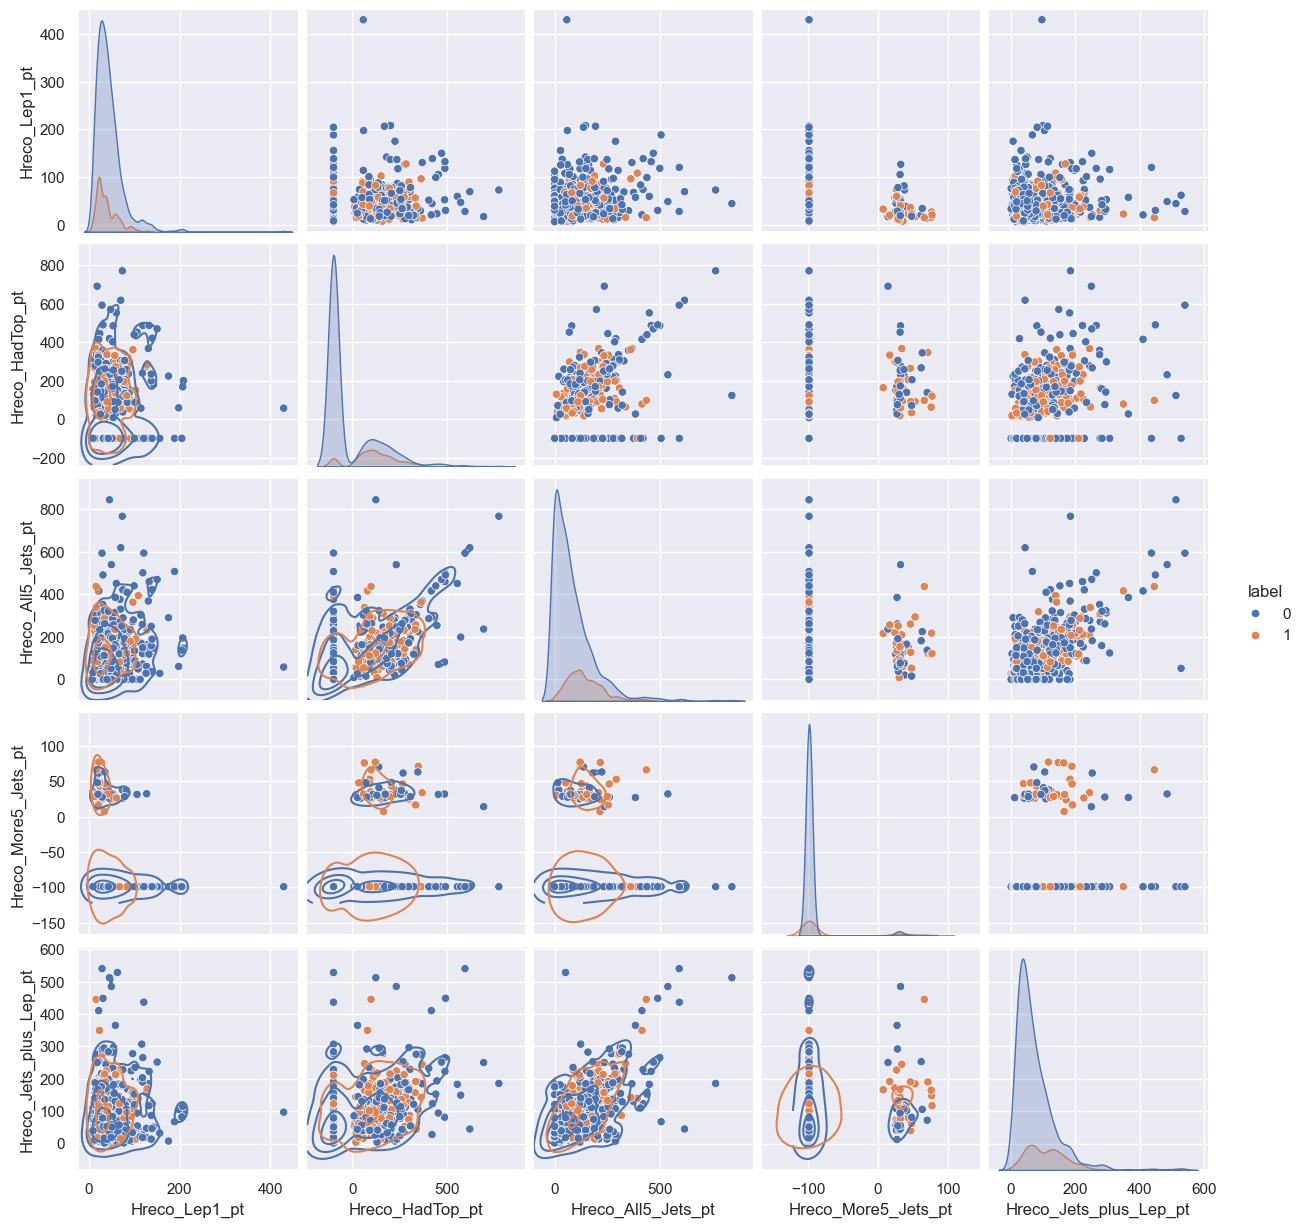

In [11]:
import seaborn as sns
sns.set()
cols_to_plot = [
    'Hreco_Lep1_pt',
    'Hreco_HadTop_pt',
    'Hreco_All5_Jets_pt',
    'Hreco_More5_Jets_pt',
    'Hreco_Jets_plus_Lep_pt',
    'label'
]
pp=sns.pairplot(data=data.sample(1000)[cols_to_plot], hue='label', diag_kws={'bw_method': 0.2})
pp.map_lower(sns.kdeplot, levels=4, color=".2") # Contours



Exercise: what happens if you plot the full list of variables (`cols_to_plot = data.columns`) from the command above? What happens if you omit `.sample(100)` from the command above?


### Split the data set into training and test set


When we train a machine learning algorithm, we are trying to solve an interpolation problem (find the function of the input features that provides the best approximation of the true function) by also requiring that the solution generalizes sufficiently well (the interpolating function must also predict correctly the value of the true function for new, unseen data).

When we have a labelled dataset, we will therefore split it into: a training set, which we will use to train the machine learning algorithm; a test set, which we will use to evaluate the performance of the algorithm for various realizations of the algorithm (e.g. tuning hyperparameters); and an application set, which are the data we are really interested in studying in the end.

For many applications, when the amount of hyperparameters tuning is moderate, application set and test set can be collapsed into a single set (usually called test set). This is what we will do in this tutorial.

![Blah](figs/trainingNetwork.png)

(Image: P. Vischia, [doi:10.5281/zenodo.6373442](https://doi.org/10.5281/zenodo.6373442))

In [12]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.33, random_state=42)

print(f"We have {len(X_train)} training samples with {sum(y_train)} signal and {sum(1-y_train)} background events")
print(f"We have {len(X_test)} testing samples with {sum(y_test)} signal and {sum(1-y_test)} background events")


We have 1266862 training samples with 200248 signal and 1066614 background events
We have 623977 testing samples with 99039 signal and 524938 background events


### Correlation matrices

For classification problems, another important thing is to take a look at the correlations between all the variables, in events belonging to each class separately.

Looking at the correlation between features can highlight pairs that are strongly correlated with each other, and one could decide to omit them since they do not add further information when the correlations are very high.

We look at the correlation for each class because we are very interested in pairs of features that have different correlation in one class or the other (in our example, signal or background).

Now we will choose a simple criterion, for instance the value of one of the features that characterize the houses, and use it to decide if the house is in New York (we want to predict 0) or in San Francisco (we want to predict 1)


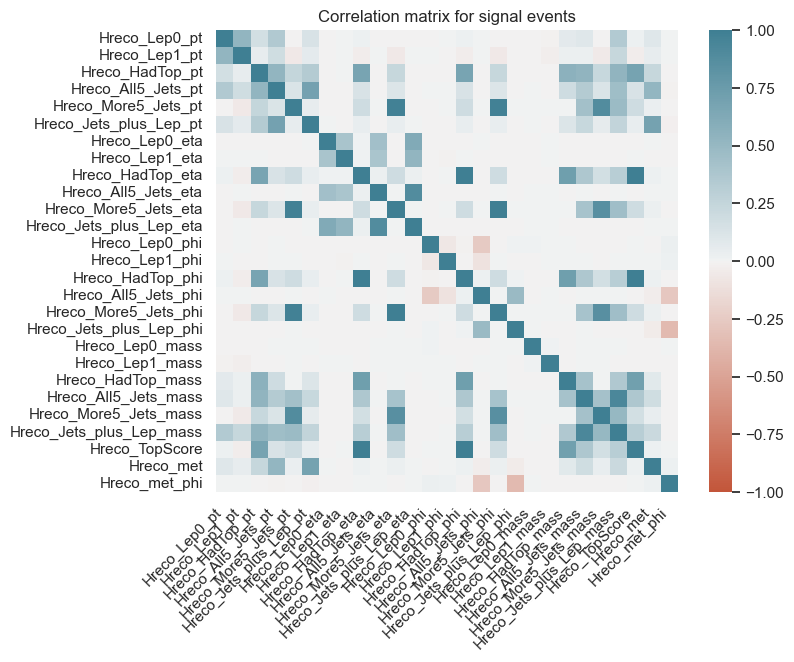

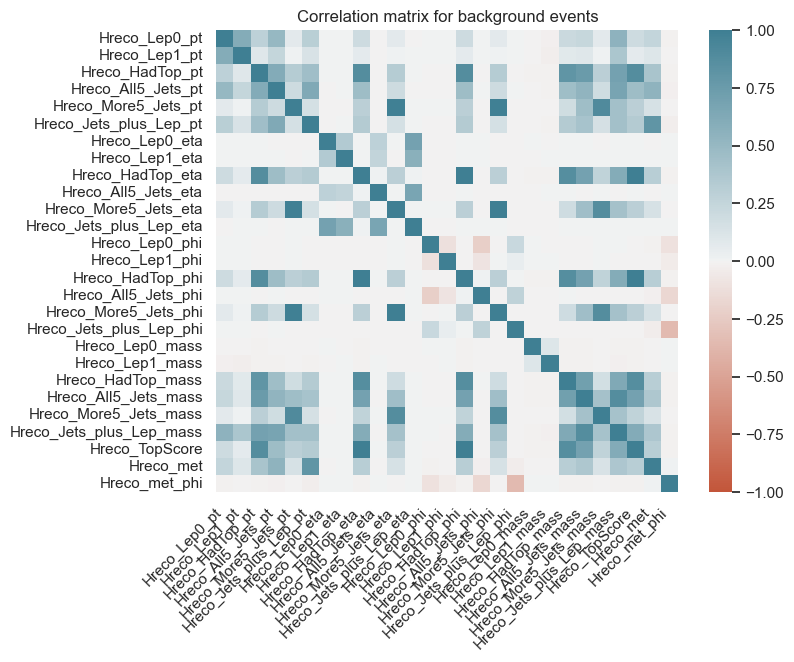

In [13]:
def corrmatrix(corr, label):
    plt.figure()
    ax = sns.heatmap(
        corr, 
        vmin=-1., vmax=1., center=0.,
        cmap=sns.diverging_palette(20., 220., n=200, as_cmap=True),
        square=True
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    );

    ax.set_title('Correlation matrix for %s events' % label)

    plt.show()
    plt.close()


corrmatrix(X_train[y_train==1.].corr(), 'signal')
corrmatrix(X_train[y_train==0.].corr(), 'background')

What we have plotted is the [Pearson correlation coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient), which leads to an important limitation of this diagnostic tool. The Pearson correlation coefficient captures only **linear** correlation between variables, and is blind to many nonlinear correlations that there may be. Don't trust the above matrices blindly.

![Figure from BDN2010](figs/corrcov.png)
(figure from C. Delaere slides at the 2010 BND school)

## Preprocess the data
Before training a first ML-based classifier we need to think about if any preprocessing of the data is required. Many ML algorithms are based on gradient minimization techniques that can fail if the inputs have numbers that widely-vary in magnitude. For example, the $p_T$ of a jet might range from 20 to 2000 GeV, covering several orders of magnitude, and can prevent the convergence of a minimization algorithm. In the case of $p_T$ a typical manual preprocessing could be to use the logarithm as input instead, ie. $\\log(p_T/1~\\textrm{GeV})$, which in particular moves.

In this data set, the features have already been scaled such that their range is around unity. Sometimes this happens naturally, but in this case several variables come directly from particle physics and represent momenta of particles produced in high-energy interaction: when expressed in GeV, these variables will most certainly **not** be in a range close to unity.

Common choices to preprocess input features automatically are minmax scaling or normalization.

###### Minmax
Compress the range linearly:
$$X_{scaled} = \\frac{X-X_{min}}{X_{max}-X_{min}}$$
A drawback is that this results in an artificially smaller variance (the range is compressed linearly), which can deform the effect of outliers.

###### Standardization
Compress the range and the shape:
$$X_{normalized} = \\frac{X - \\mu}{\\sigma}$$
where $\\mu$ is the mean of the feature values and $\\sigma$ is the standard deviation.\n",

###### Which one?
- Typically one would use minmax scaling when your features are remarkably nongaussian and your ML algorithm of choice doesn't require Gaussian inputs. The price is that it affects outliers.
- Typically one would use normalization when the features are approximately Gaussian or when your ML algorithm of choice requires Gaussian inputs. However, it also results in numbers close to 1 (minimization algorithms and gradient descend love numbers that are not too large or too small), so it can be used for any algorithm: the good news is that it doesn't affect outliers.

You can also apply PCA, as we have discussed in the lectures. The code below imports the most common scalers, for you to play with.

For now, let's use the standard scaler for the input features of the dense NN. You are encouraged to try out the others!

We will also store the original train and test structures, because for the convolutional network we will preprocess them differently.


In [14]:
X_train_conv = X_train.copy()
y_train_conv = y_train.copy()
X_test_conv = X_test.copy()
y_test_conv = y_test.copy()

from sklearn.preprocessing import (
    MaxAbsScaler, # maxAbs
    MinMaxScaler, # MinMax
    Normalizer, # Normalization (equal integral)
    StandardScaler# standard scaling
)
from sklearn.decomposition import PCA

# Scale the input features and the target variable
for column in X_train.columns:
    scaler = StandardScaler().fit(X_train.filter([column], axis=1))
    X_train[column] = scaler.transform(X_train.filter([column], axis=1))
    X_test[column] = scaler.transform(X_test.filter([column], axis=1))



You could also use the basic syntax recommended by the documentation, as follows, but then you would be standardizing all the features to exacly the same mean. This may work for some data sets, but for this specific one it does not (it actually significantly worsens the performance---you can try ;) ).

In [15]:
#scaler = StandardScaler().fit(X_train[X_train.columns])
#X_train[X_train.columns] = scaler.transform(X_train[X_train.columns])
#X_test[X_test.columns] = scaler.transform(X_test[X_test.columns])

## Train a dense neural network


For neural networks we will use `pytorch`, a backend designed natively for tensor operations.
I prefer it to tensorflow, because it exposes (i.e. you have to call them explicitly in your code) the optimizer steps and the backpropagation steps.

You could also use the `tensorflow` backend, either directly or through the `keras` frontend.
Saying "I use keras" does not tell you which backend is being used. It used to be either `tensorflow` or `theano`. Nowadays `keras` is I think almost embedded inside tensorflow, but it is still good to specify.

`torch` handles the data management via the `Dataset` and `DataLoader` classes.
Here we don't need any specific `Dataset` class, because we are not doing sophisticated things, but you may need that in the future.

The `Dataloader` class takes care of providing quick access to the data by sampling batches that are then fed to the network for (mini)batch gradient descent.
                                                                                                                            
                                                                                                                            

Set a manual seed, for reproducibility

In [16]:
torch.manual_seed(42)


In [17]:
class MyDataset(Dataset):
    def __init__(self, X, y, device=torch.device("cpu")):
        self.X = torch.Tensor(X.values if isinstance(X, pd.core.frame.DataFrame) else X).to(device)
        self.y = torch.Tensor(y.values).to(device)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        label = self.y[idx]
        datum = self.X[idx]
        
        return datum, label

batch_size=1024 # Minibatch learning


train_dataset = MyDataset(X_train, y_train)
test_dataset = MyDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")


Feature batch shape: torch.Size([1024, 27])
Labels batch shape: torch.Size([1024])


For educational purposes, let's get access the data loader via its iterator, and sample a single batch by calling `next` on the iterator

Let's build a simple neural network, by inheriting from the `nn.Module` class. **This is very crucial, because that class is the responsible for providing the automatic differentiation infrastructure for tracking parameters and performing backpropagation**

In [18]:
class NeuralNetwork(nn.Module):
    def __init__(self, ninputs, device=torch.device("cpu")):
        super().__init__()
        self.device = device
        
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(ninputs, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64,8),
            nn.ReLU(),
            nn.Linear(8, 1),
            nn.Sigmoid()
        )
        self.linear_relu_stack.to(device)

    def forward(self, x):
        # Pass data through conv1
        x = self.linear_relu_stack(x)
        return x

Let's instantiate the neural network and print some info on it

In [19]:
model = NeuralNetwork(X_train.shape[1])

print(model) # some basic info

print("Now let's see some more detailed info by using the torchinfo package")
torchinfo.summary(model, input_size=(batch_size, X_train.shape[1])) # the input size is (batch size, number of features)

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=27, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=8, bias=True)
    (7): ReLU()
    (8): Linear(in_features=8, out_features=1, bias=True)
    (9): Sigmoid()
  )
)
Now let's see some more detailed info by using the torchinfo package


Layer (type:depth-idx)                   Output Shape              Param #
NeuralNetwork                            [1024, 1]                 --
├─Sequential: 1-1                        [1024, 1]                 --
│    └─Linear: 2-1                       [1024, 512]               14,336
│    └─ReLU: 2-2                         [1024, 512]               --
│    └─Linear: 2-3                       [1024, 128]               65,664
│    └─ReLU: 2-4                         [1024, 128]               --
│    └─Linear: 2-5                       [1024, 64]                8,256
│    └─ReLU: 2-6                         [1024, 64]                --
│    └─Linear: 2-7                       [1024, 8]                 520
│    └─ReLU: 2-8                         [1024, 8]                 --
│    └─Linear: 2-9                       [1024, 1]                 9
│    └─Sigmoid: 2-10                     [1024, 1]                 --
Total params: 88,785
Trainable params: 88,785
Non-trainable params: 0
Tota

Now let's introduce a crucial concept: `torch` lets you manage in which device you want to put your data and models, to optimize access at different stages

In [20]:
device = torch.device("cpu")

if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
if torch.cuda.is_available() and torch.cuda.device_count()>0:
    device = torch.device("cuda")
    
print ("Available device: ",device)


# Get a batch from the dataloader
random_batch_X, random_batch_y = next(iter(train_dataloader))

print("The original dataloader resides in", random_batch_X.get_device())

# Let's reinstantiate the dataset
train_dataset = MyDataset(X_train, y_train, device=device)
test_dataset = MyDataset(X_test, y_test, device=device)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

random_batch_X, random_batch_y = next(iter(train_dataloader))

print("The new dataloader puts the batches in in", random_batch_X.get_device())

# Reinstantiate the model, on the chosen device
model = NeuralNetwork(X_train.shape[1], device)

#check if the NN can be evaluated some data; note: it has not been trained yet
print (model(torch.tensor(X_train.values[:10],device=device)))

Available device:  mps
The original dataloader resides in -1
The new dataloader puts the batches in in 0
tensor([[0.4526],
        [0.4534],
        [0.4516],
        [0.4525],
        [0.4520],
        [0.4536],
        [0.4526],
        [0.4522],
        [0.4518],
        [0.4500]], device='mps:0', grad_fn=<SigmoidBackward0>)


We have learned how load the data into the GPU, how to define and instantiate a model. Now we need to define a training loop.

In `keras`, this is wrapped hidden into the `.fit()` method, which I think is bad because it hides the actual procedure.

In [21]:
def train_loop(dataloader, model, loss_fn, optimizer, scheduler, device):
    size = len(dataloader.dataset)
    losses=[] # Track the loss function
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    #for batch, (X, y) in enumerate(dataloader):
    for (X,y) in tqdm(dataloader):
        # Reset gradients (to avoid their accumulation)
        optimizer.zero_grad()
        # Compute prediction and loss
        pred = model(X)
        #if (all_equal3(pred.detach().numpy())):
        #    print("All equal!")
        loss = loss_fn(pred.squeeze(dim=1), y)
        losses.append(loss.detach().cpu())
        # Backpropagation
        loss.backward()
        optimizer.step()

    scheduler.step()
    return np.mean(losses)

Now we need to define the loop that is run on the test dataset.

**The test dataset is just used for evaluating the output of the model. No backpropagation is needed, therefore backpropagation must be switched off!!!**

In [22]:
def test_loop(dataloader, model, loss_fn, device):
    losses=[] # Track the loss function
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        #for X, y in dataloader:
        for (X,y) in tqdm(dataloader):
            pred = model(X)
            loss = loss_fn(pred.squeeze(dim=1), y).item()
            losses.append(loss)
            test_loss += loss
            #correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            
    return np.mean(losses)

We are now read to train this network!
At the moment we are trying to do classification. We will set our loss function to be the cross entropy.

Torch provides the functionality to use generic functions as loss function. We will show an example one.

In [23]:
epochs=10
learningRate = 0.01

# The loss defines the metric deciding how good or bad is the prediction of the network
loss_fn = torch.nn.BCELoss()
# The optimizer decides which path to follow through the gradient of the loss function
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)
# The scheduler reduces the learning rate for the optimizer in order to for the optimizer to be able to "enter" narrow minima
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)


In [24]:
train_losses=[]
test_losses=[]
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss=train_loop(train_dataloader, model, loss_fn, optimizer, scheduler, device)
    test_loss=test_loop(test_dataloader, model, loss_fn, device)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    print("Avg train loss", train_loss, ", Avg test loss", test_loss, "Current learning rate", scheduler.get_last_lr())
print("Done!")

Epoch 1
-------------------------------


100%|███████████████████████████████████████████████████████████████████| 610/610 [00:11<00:00, 50.85it/s]


Avg train loss 0.45890045 , Avg test loss 0.38094801458178973 Current learning rate [0.009000000000000001]
Epoch 2
-------------------------------


100%|███████████████████████████████████████████████████████████████████| 610/610 [00:12<00:00, 49.88it/s]


Avg train loss 0.34783068 , Avg test loss 0.3365319227097464 Current learning rate [0.008100000000000001]
Epoch 3
-------------------------------


100%|███████████████████████████████████████████████████████████████████| 610/610 [00:12<00:00, 49.41it/s]


Avg train loss 0.33146733 , Avg test loss 0.3286706547756664 Current learning rate [0.007290000000000001]
Epoch 4
-------------------------------


100%|███████████████████████████████████████████████████████████████████| 610/610 [00:12<00:00, 49.46it/s]


Avg train loss 0.3259978 , Avg test loss 0.3248601624711615 Current learning rate [0.006561000000000002]
Epoch 5
-------------------------------


100%|███████████████████████████████████████████████████████████████████| 610/610 [00:12<00:00, 49.53it/s]


Avg train loss 0.32278857 , Avg test loss 0.32219661723394866 Current learning rate [0.005904900000000002]
Epoch 6
-------------------------------


100%|███████████████████████████████████████████████████████████████████| 610/610 [00:12<00:00, 49.40it/s]


Avg train loss 0.32052818 , Avg test loss 0.320318752722662 Current learning rate [0.005314410000000002]
Epoch 7
-------------------------------


100%|███████████████████████████████████████████████████████████████████| 610/610 [00:12<00:00, 48.78it/s]


Avg train loss 0.31885856 , Avg test loss 0.31881823485991995 Current learning rate [0.004782969000000002]
Epoch 8
-------------------------------


100%|███████████████████████████████████████████████████████████████████| 610/610 [00:12<00:00, 49.69it/s]


Avg train loss 0.3173942 , Avg test loss 0.3174883183885793 Current learning rate [0.004304672100000002]
Epoch 9
-------------------------------


100%|███████████████████████████████████████████████████████████████████| 610/610 [00:12<00:00, 49.15it/s]


Avg train loss 0.31614023 , Avg test loss 0.3163512245064876 Current learning rate [0.003874204890000002]
Epoch 10
-------------------------------


100%|███████████████████████████████████████████████████████████████████| 610/610 [00:12<00:00, 49.11it/s]

Avg train loss 0.31508034 , Avg test loss 0.3153735952299149 Current learning rate [0.003486784401000002]
Done!


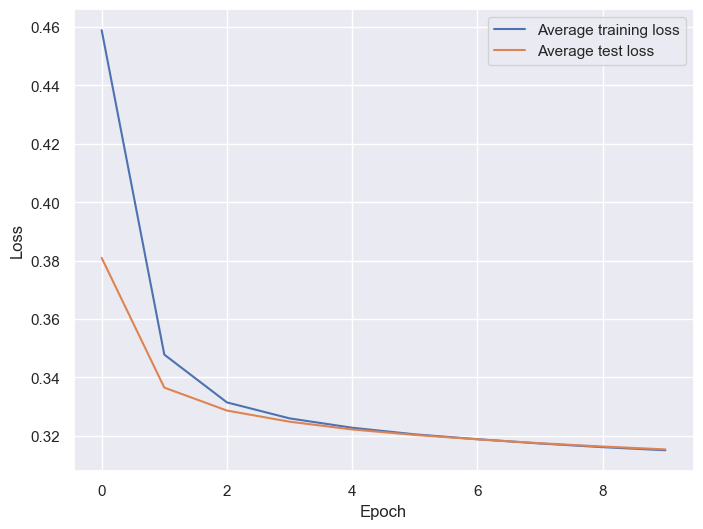

In [25]:
plt.figure()
plt.plot(train_losses, label="Average training loss")
plt.plot(test_losses, label="Average test loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="best")
plt.show()
plt.close()

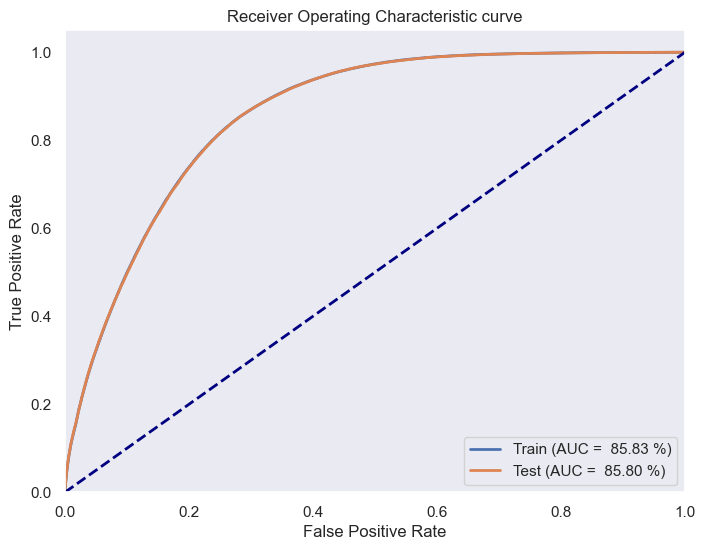

In [26]:
def plot_rocs(scores_labels_names):
    plt.figure()
    for score, label, name  in scores_labels_names:
        fpr, tpr, thresholds = roc_curve(label, score)
        plt.plot(
            fpr, tpr, 
            linewidth=2, 
            label=f"{name} (AUC = {100.*auc(fpr, tpr): .2f} %)"
        )
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.grid()
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic curve")
    plt.legend(loc="lower right")
    plt.show()
    plt.close()

plot_rocs([
    (model(torch.tensor(X_train.to_numpy(),device=model.device)).numpy(force=True), y_train, "Train"), 
    (model(torch.tensor(X_test.to_numpy(),device=model.device)).numpy(force=True), y_test, "Test")  
])

## Train a convolutional neural network

We will now build and train a convolutional neural network, which is a special type of neural network that is very well suited to analyze data where features depend on each other depending on a notion of proximity between the features in the data vector ordering.

Convolutional neural networks are based on the convolution operation, which provides an input that averages neighbouring features (where neighbour means in terms of the position in the data vector---for an image, closeness of the pixel):


$$s(t) = \int x(a) w(t-a)da$$

- When discretized, integral becomes a sum
  - $x$ input
  - $w$ kernel: specifies how far does the averaging goes
  - $s$ feature map

Convolutional networks are also based on the concept of `parameter sharing`, that enables invariance by translations (recognize the same pattern in different places of the "image"), and of `pooling`, that is averaging classification patterns.

To build a convolutional network, we will need to change two main things compared to the dense network:

- encode the data in a way that makes them similar to an image
- build a network using layers that implement convolution and pooling operations


 

### Build a 2D "image" for the event, based on the $\eta$ and $\phi$ coordinates of the leptons

In [27]:
# Digitization courtesy Evan Armstrong König

# list all objects that have eta/phi coordinates
objects = [
    "Hreco_Lep0",
    "Hreco_Lep1",
    # "Hreco_HadTop",
    "Hreco_All5_Jets",
    # "Hreco_More5_Jets",
    "Hreco_Jets_plus_Lep",
]

def digitize(x, bins):
    # digitize x into bins
    idx = np.digitize(x, bins) - 1

    # clip values outside the bins
    idx = np.clip(idx, 0, len(bins)-2)
    return idx

def build_image(X, Nbins=5, transforms=[]):
    """
    Build a 2d image of energy deposits
    """

    # using the eta and phi coordinates as x and y
    for obj in objects:
        X[f'{obj}_x'] = X[f'{obj}_eta']
        X[f'{obj}_y'] = X[f'{obj}_phi']

    # apply any transformations to the coordinates
    for transform in transforms:
        X = transform(X)

    index = np.arange(len(X))
    eta_edges = np.linspace(-5, 5, Nbins+1)
    phi_edges = np.linspace(-3.2, 3.2, Nbins+1)

    # create the image with the energy deposits
    img = np.zeros((len(X), 1, Nbins, Nbins))
    for obj in objects:
        et = np.sqrt(X[f"{obj}_pt"]**2 + X[f"{obj}_mass"]**2)
        eta_bin = digitize(X[f"{obj}_x"], eta_edges)
        phi_bin = digitize(X[f"{obj}_y"], phi_edges)
        img[index, 0, eta_bin, phi_bin] += et

    # use the log of the energy instead
    img[img > 0] = np.log(img[img > 0])
    return img

In [28]:
# special image feature scaler that ignores the empty pixels in our images
class ImageMinMaxScaler:
    def __init__(self):
        self.max = None
        self.min = None

    def fit(self, img):
        self.max = np.array([ F[F != 0].max() for F in img.transpose(1, 0, 2, 3) ])[None, :, None, None]
        self.min = np.array([ F[F != 0].min() for F in img.transpose(1, 0, 2, 3) ])[None, :, None, None]

    def transform(self, img):
        return np.where(img != 0, (img - self.min) / (self.max - self.min), 0)

    def fit_transform(self, img):
        self.fit(img)
        return self.transform(img)


In [29]:
scaler = ImageMinMaxScaler()

img_train = build_image(X_train_conv, Nbins=5)
img_test = build_image(X_test_conv, Nbins=5)


img_train = scaler.fit_transform(img_train)
img_test = scaler.transform(img_test)

print (f"Image format: {img_train.shape}")

Image format: (1266862, 1, 5, 5)


### Display an example image
Courtesy Evan Armstrong König


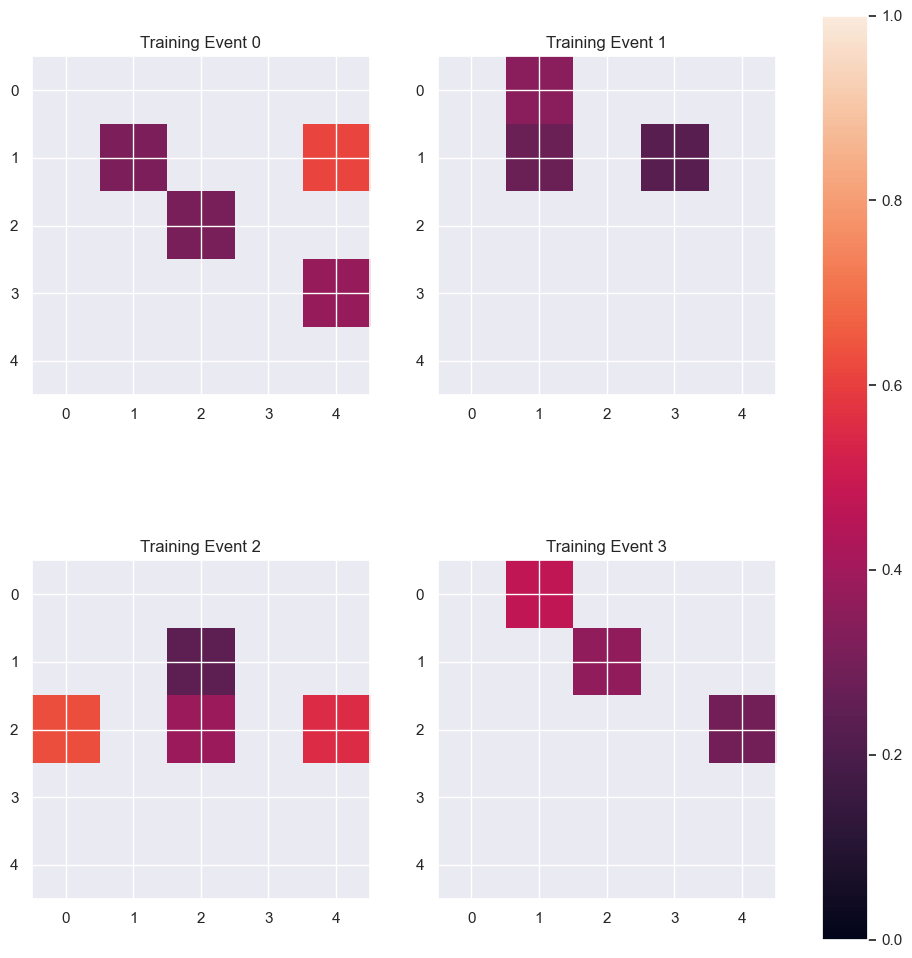

In [30]:
import matplotlib.colors as mcolor

norm = mcolor.Normalize(vmin=0, vmax=1)

def plot_event_image(ax, img, title):
    img = np.where(img != 0, img, np.nan)
    c = ax.imshow(img[0], norm=norm)
    ax.set_title(title)
    return c

fig, axs = plt.subplots(2, 2, figsize=[12,12])
c0 = plot_event_image(axs[0, 0], img_train[0], 'Training Event 0')
c1 = plot_event_image(axs[0, 1], img_train[1], 'Training Event 1')
c2 = plot_event_image(axs[1, 0], img_train[2], 'Training Event 2')
c3 = plot_event_image(axs[1, 1], img_train[3], 'Training Event 3')

fig.colorbar(c0, ax=axs)
plt.show()
plt.close()

Now we are ready to build again our dataset and dataloader, in the same way as we did above for the dense NN.

In [31]:
class MyCNNDataset(Dataset):
    def __init__(self, X, y, device=torch.device("cpu")):
        self.X = torch.Tensor(X.values if isinstance(X, pd.core.frame.DataFrame) else X).to(device)
        self.y = torch.Tensor(y.values if isinstance(X, pd.core.frame.DataFrame) else y.to_numpy()).to(device)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        label = self.y[idx]
        datum = self.X[idx]
        
        return datum, label
    
train_dataset_conv = MyCNNDataset(img_train, y_train_conv, device=device)
test_dataset_conv = MyCNNDataset(img_test, y_test_conv, device=device)

batch_size=2048
train_dataloader_conv = DataLoader(train_dataset_conv, batch_size=batch_size, shuffle=True)
test_dataloader_conv = DataLoader(test_dataset_conv, batch_size=batch_size, shuffle=False)


We can now build our new convolutional network. The way it typically works is to have a convolutional structure first, to analyze the image and extract its relevant features, and then a small linear (dense) layer or set of layers to perform the final classification task.

Relevant parameters for a convolutional layer are the number of input and of output channels. Channels are the representations of the same image area in different ways: for instance, a black-and-white image has $n\times m$ pixels and one channel (the grey scale); an RGB image has three channels: one $n\times m$ array per each of the three primary colours. This can be generalized to any "pseudo-image" you may be trying to use. The output channels refer to the amount of simultaneous representations of the image (each one through one different convolutional kernel) should be produced by the convolutional layer. It is advantageous to set a non-1 value for the number of output channels of a convolutional layer, because (by requiring one kernel per each of the output channels) it results in learnable parameters that can focus on different aspects of the "image".

For our application, the number of channels will be determined by the procedure we used to digitize the input data into "images", therefore we will take if from the batch characteristics:

In [32]:

batch_x, batch_y = next(iter(train_dataloader_conv))
_, n_channels, img_height, img_width = batch_x.shape
print(batch_x.shape)

torch.Size([2048, 1, 5, 5])


We are now ready to build the model, which will be made out of two part:
- a convolutional part, tasked with image processing
- a dense part, tasked with the final classification.

We will select a kernel size of $(2,2)$, indicating that we want to average only the pixels in the immediate vicinities. You can play with this parameter.

In the structure below, the first `Conv2d` layer has $32$ output channels and therefore it has $32$ kernels (each of the specified size $2x2$), i.e. splits the image in thirty-two separate channels each with its own convolution operation. Padding ensures the size of the image remains the same. The second Conv2d layer has $16$ filters, also with a $3x3$ kernel.

The MaxPool2d layer has a 2x2 kernel and a stride of 2. This does averaging and dimensional reduction, downsampling the image by a factor 2 in each dimension (from 28x28 to 14x14 the first time we apply it, and from 14x14 to 7x7 the second time).

The output of the second Conv2d layer will therefore a 16-channel image where each channel is 7x7. We flatten it to a one-dimensional vector per image to feed it to a dense layer that does classification.



In [33]:
class ConvNetwork(nn.Module):
    def __init__(self, in_channels, height, width, device=torch.device("cpu")):
        super().__init__()
        self.device = device
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(), 
            # For MaxPool2d, dim_out = (dim_in + 2*padding - dilation *(kernelsize-1) -1)/stride -1 , default dilation is 1, default padding 0
            nn.MaxPool2d(kernel_size=(2, 2), stride=(1, 1)), 
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            # We won't put another pooling layer, because the "image" is already rather small            
            nn.Flatten(),
        )
        self.conv.to(self.device)
        # acquire the output shape of the convolutional layer
        _, F = self.conv(torch.zeros(1, in_channels, height, width, device=self.device)).shape
        self.dense = nn.Sequential(
            # acquire the output shape of the convolutional layer
            nn.Linear(F, 1),
            nn.Sigmoid()
        )
        self.dense.to(self.device)
            # Another activation function here? Or not?
    def set_device(self, device):
        # Needed to fix the issue with conv2d channels in pytorch under MPS devices (fixed in torch 2.7.0.dev20250105 and above)
        self.device=device
        self.conv.to(device)
        self.dense.to(device)
    def forward(self, x):
        x.to(self.device)
        x = self.conv(x)
        x = self.dense(x)
        return x
    
    


Let's instantiate the model and print some info on it

In [34]:
conv_model = ConvNetwork(n_channels, img_height, img_width, device=device)
print(conv_model) # some basic info
conv_model(batch_x)
print("Now let's see some more detailed info by using the torchinfo package")
torchinfo.summary(conv_model, input_size=batch_x.shape, device=device) # the input size is (batch size, number of features)

ConvNetwork(
  (conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 16, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): Flatten(start_dim=1, end_dim=-1)
  )
  (dense): Sequential(
    (0): Linear(in_features=576, out_features=1, bias=True)
    (1): Sigmoid()
  )
)
Now let's see some more detailed info by using the torchinfo package


Layer (type:depth-idx)                   Output Shape              Param #
ConvNetwork                              [2048, 1]                 --
├─Sequential: 1-1                        [2048, 576]               --
│    └─Conv2d: 2-1                       [2048, 32, 6, 6]          160
│    └─ReLU: 2-2                         [2048, 32, 6, 6]          --
│    └─MaxPool2d: 2-3                    [2048, 32, 5, 5]          --
│    └─Conv2d: 2-4                       [2048, 16, 6, 6]          2,064
│    └─ReLU: 2-5                         [2048, 16, 6, 6]          --
│    └─Flatten: 2-6                      [2048, 576]               --
├─Sequential: 1-2                        [2048, 1]                 --
│    └─Linear: 2-7                       [2048, 1]                 577
│    └─Sigmoid: 2-8                      [2048, 1]                 --
Total params: 2,801
Trainable params: 2,801
Non-trainable params: 0
Total mult-adds (M): 165.15
Input size (MB): 0.20
Forward/backward pass size (MB):

### Number of parameters

The convolutional network we are using has about 3k parameters, whereas the dense networks has about 90k.

In [35]:
def get_trainable_parameters(mod):
    model_parameters = filter(lambda p: p.requires_grad, mod.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    return params
print(f"The dense network has: {get_trainable_parameters(model)} trainable parameters")
print(f"The convolutional network has {get_trainable_parameters(conv_model)} trainable parameters")

The dense network has: 88785 trainable parameters
The convolutional network has 2801 trainable parameters


### Train the convolutional network

We can now train the convolutional neural network. Since the target is the same (classification), we can use exactly the same settings and training/test loops:


In [37]:
epochs=10
learningRate = 0.01

# The loss defines the metric deciding how good or bad is the prediction of the network
conv_loss_fn = torch.nn.BCELoss()
# The optimizer decides which path to follow through the gradient of the loss function
conv_optimizer = torch.optim.SGD(conv_model.parameters(), lr=learningRate)
# The scheduler reduces the learning rate for the optimizer in order to for the optimizer to be able to "enter" narrow minima
conv_scheduler = torch.optim.lr_scheduler.ExponentialLR(conv_optimizer, gamma=0.9)


In [38]:
conv_train_losses=[]
conv_test_losses=[]
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss=train_loop(train_dataloader_conv, conv_model, conv_loss_fn, conv_optimizer, conv_scheduler, device)
    test_loss=test_loop(test_dataloader_conv, conv_model, conv_loss_fn, device)
    conv_train_losses.append(train_loss)
    conv_test_losses.append(test_loss)
    print("Avg train loss", train_loss, ", Avg test loss", test_loss, "Current learning rate", conv_scheduler.get_last_lr())
print("Done!")

Epoch 1
-------------------------------


100%|███████████████████████████████████████████████████████████████████| 305/305 [00:12<00:00, 24.99it/s]


Avg train loss 0.44842815 , Avg test loss 0.4368207782995505 Current learning rate [0.009000000000000001]
Epoch 2
-------------------------------


100%|███████████████████████████████████████████████████████████████████| 305/305 [00:11<00:00, 26.02it/s]


Avg train loss 0.43386403 , Avg test loss 0.43282527962669 Current learning rate [0.008100000000000001]
Epoch 3
-------------------------------


100%|███████████████████████████████████████████████████████████████████| 305/305 [00:12<00:00, 25.01it/s]


Avg train loss 0.4294961 , Avg test loss 0.42810666688153 Current learning rate [0.007290000000000001]
Epoch 4
-------------------------------


100%|███████████████████████████████████████████████████████████████████| 305/305 [00:11<00:00, 25.80it/s]


Avg train loss 0.42481306 , Avg test loss 0.4236868189983681 Current learning rate [0.006561000000000002]
Epoch 5
-------------------------------


100%|███████████████████████████████████████████████████████████████████| 305/305 [00:11<00:00, 25.97it/s]


Avg train loss 0.4208603 , Avg test loss 0.4203010305029447 Current learning rate [0.005904900000000002]
Epoch 6
-------------------------------


100%|███████████████████████████████████████████████████████████████████| 305/305 [00:11<00:00, 25.95it/s]


Avg train loss 0.41801938 , Avg test loss 0.41789814106753614 Current learning rate [0.005314410000000002]
Epoch 7
-------------------------------


100%|███████████████████████████████████████████████████████████████████| 305/305 [00:12<00:00, 24.99it/s]


Avg train loss 0.41588745 , Avg test loss 0.4160759503724145 Current learning rate [0.004782969000000002]
Epoch 8
-------------------------------


100%|███████████████████████████████████████████████████████████████████| 305/305 [00:12<00:00, 25.20it/s]


Avg train loss 0.4143024 , Avg test loss 0.41465850013201355 Current learning rate [0.004304672100000002]
Epoch 9
-------------------------------


100%|███████████████████████████████████████████████████████████████████| 305/305 [00:11<00:00, 25.93it/s]


Avg train loss 0.4130518 , Avg test loss 0.413576117695355 Current learning rate [0.003874204890000002]
Epoch 10
-------------------------------


100%|███████████████████████████████████████████████████████████████████| 305/305 [00:11<00:00, 25.56it/s]

Avg train loss 0.41206753 , Avg test loss 0.41270155027264455 Current learning rate [0.003486784401000002]
Done!


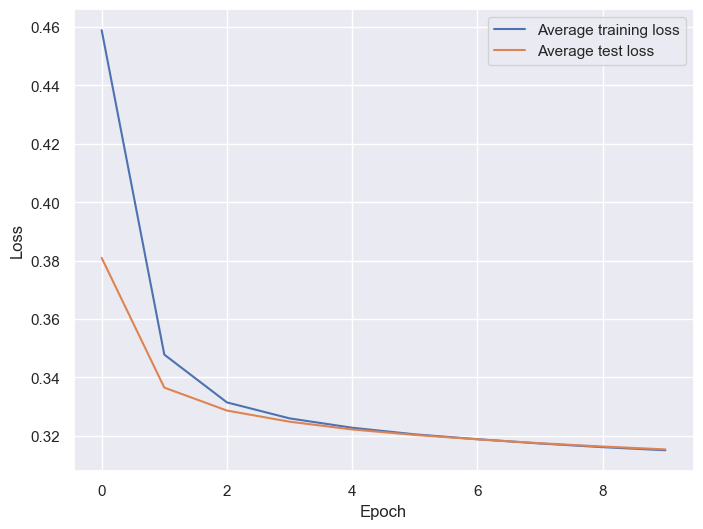

In [39]:
plt.figure()
plt.plot(train_losses, label="Average training loss")
plt.plot(test_losses, label="Average test loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="best")
plt.show()
plt.close()

We can now compare the ROC curves obtained for the convolutional network with those obtained for the dense network

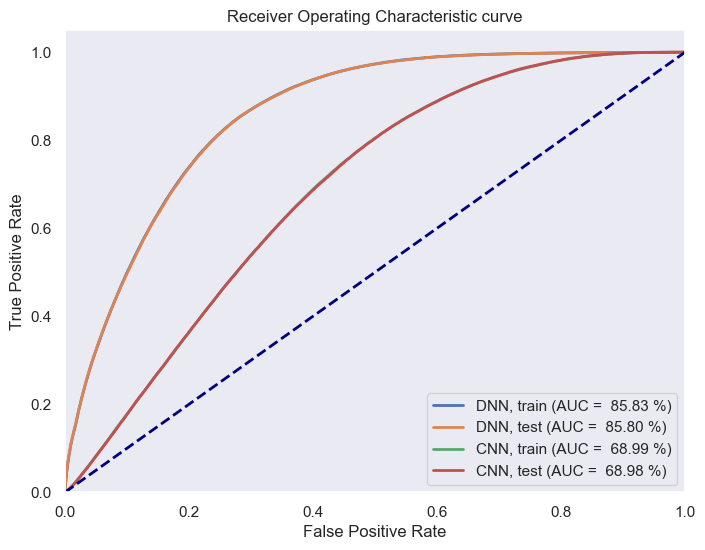

In [40]:
def plot_rocs(scores_labels_names):
    plt.figure()
    for score, label, name  in scores_labels_names:
        fpr, tpr, thresholds = roc_curve(label, score)
        plt.plot(
            fpr, tpr, 
            linewidth=2, 
            label=f"{name} (AUC = {100.*auc(fpr, tpr): .2f} %)"
        )
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.grid()
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic curve")
    plt.legend(loc="lower right")
    plt.show()
    plt.close()


conv_model.set_device(torch.device("cpu"))
conv_model.to(torch.device("cpu"))

plot_rocs([
    (model(torch.tensor(X_train.to_numpy(),device=model.device)).numpy(force=True), y_train, "DNN, train"), 
    (model(torch.tensor(X_test.to_numpy(),device=model.device)).numpy(force=True), y_test, "DNN, test"),
    (conv_model(torch.tensor(img_train, device=conv_model.device, dtype=torch.float32)).detach().numpy(), y_train_conv, "CNN, train"), 
    (conv_model(torch.tensor(img_test, device=conv_model.device, dtype=torch.float32)).detach().numpy(), y_test_conv, "CNN, test"),
])